In [40]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from statsmodels.tsa.arima.model import ARIMA

# Forecasting a Time Series using RNNs

Forecasting the number of passengers that will ride on bus and rail the next day.

We'll use the daily ridership data since 2001. This is a multivariate time series - we have multiple values (bus and train
riders) per time step.

In [2]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

'./datasets/ridership.tgz'

In [3]:
path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])

df.columns = ["date", "day_type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date")

# No need for total it's just bus + rail
df = df.drop("total", axis=1)

# Now that month is the index, it'll drop duplicate months
df = df.drop_duplicates()

# day_type: W - weekdays, A - Saturdays, U - Sundays
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


<Axes: xlabel='date'>

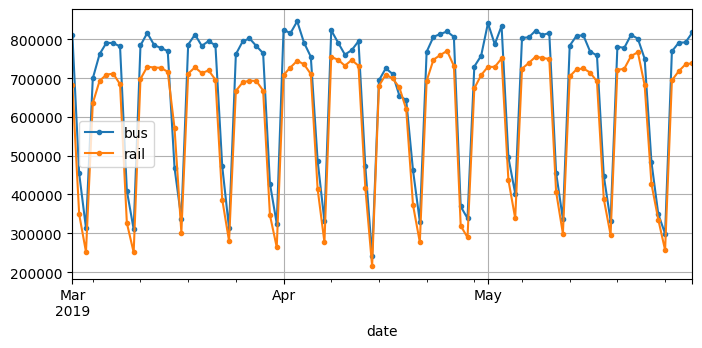

In [7]:
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8,3.5))

### Creating a naive baseline

First we want to plot the values at time t and the values at time t+7 super imposed over each other for a time period of 3 months.
This will help us understand how well a naive a baseline with a period of 7 days can work. The lines will be almost over each other
which tells us that it's going to be a good naive baseline.

The second plot is called the `differencing`. We simply take the difference of bus and rails at time t and time t-7.


<Axes: xlabel='date'>

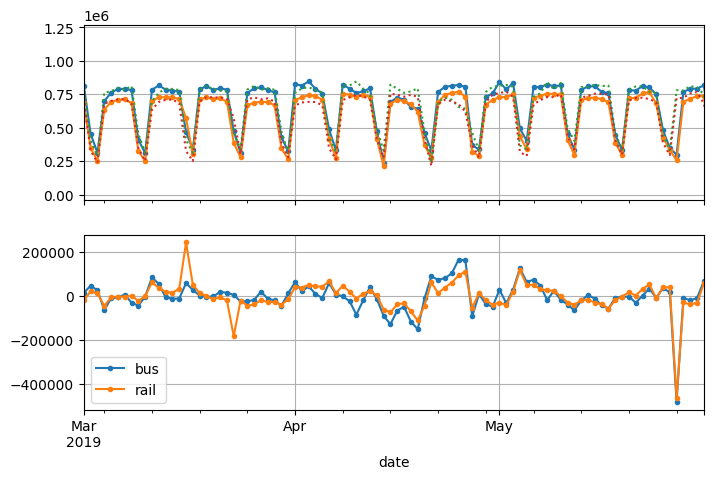

In [18]:
# Getting the difference between bus and rail at time t and bus and rail at time t-7
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2,1, sharex=True, figsize=(8,5))

# The original time series
df.plot(ax=axs[0], legend=False, marker=".")

# Lagged time series. 
# Shift takes the values at time step t and puts them at time t+n
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")

# Note the big difference at the end of May. This means that the values from time t and the values from time t-7 at t="end of may", 
# were wildly different. Why? because that was a long weekend (holiday), which changed the seasonality.
diff_7.plot(ax=axs[1], grid=True, marker=".")

In [26]:
# Getting the absolute mean of the diff(7) data frame. This tells us the MAE of our naive forecast.
print (diff_7.abs().mean())

# The MAE gives a number of wrong ridership predictions (e.g 43,000 bus riders were misclassified on average), but this doesn't
# give us a ratio. Let's divide it by total number of riders for that time period.
# We see that our naive forecast has 8%-9% error rate for both bus and rail.
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
mape = (diff_7 / targets).abs().mean()
print (mape)

bus     43915.608696
rail    42143.271739
dtype: float64
bus     0.082938
rail    0.089948
dtype: float64


### Trying to find longer term trends

We clearly saw the weekly seasonality of the data when we plotted the data. 

Can there be additional seasonality trends in the data, for example, yearly or monthly?

<Axes: xlabel='date'>

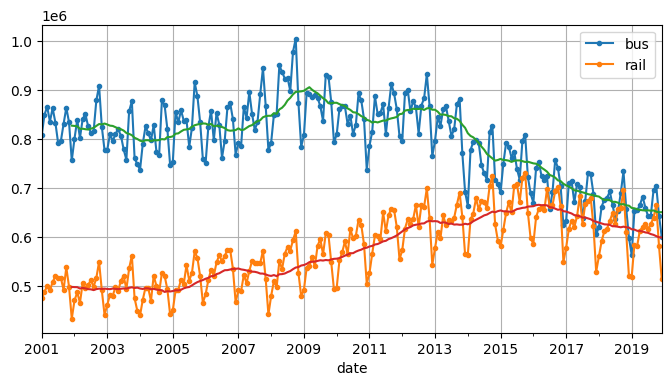

In [36]:
period = slice("2001", "2019")

# Compute the mean for each month
df_monthly = df[["bus", "rail"]].resample('M').mean()
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8,4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)


<Axes: xlabel='date'>

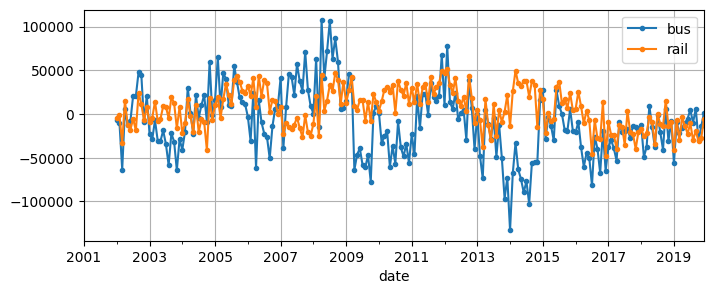

In [39]:
# Getting the differencing for the monthly data between 2001 to 2019
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8,3))

## ARIMA - Autoregressive integrated moving average

This model runs d rounds of differencing to make the time series more stationary, then it applies regular ARMA when making
forecasts.

In [47]:
origin, today = "2019-01-01", "2019-05-31"

# Let's the ARIMA model know that the frequency of this time series is day (D)
rail_series = df.loc[origin:today]["rail"].asfreq("D")

# order is p,d,q
# seasonal_order is P,D,Q,s
model = ARIMA(rail_series, order=(1,0,0), seasonal_order=(0,1,1,7))
model = model.fit()

# Predict the next day
y_pred = model.forecast()

In [48]:
# This outputs 427758.62629 which is 12.9% off the actual value (379,044). This one off prediction is worse 
# then our baseline...
print (y_pred)

2019-06-01    427758.62629
Freq: D, dtype: float64


In [55]:
# Running the model in a loop to get the forecasts for multiple consecutive days and computing the error rate

origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")

y_preds = []
# starts a day before the time period start date
for today in time_period.shift(-1):
  # train data from origin up to today
  model = ARIMA(rail_series[origin:today], order=(1,0,0), seasonal_order=(0,1,1,7))
  model = model.fit()

  y_pred = model.forecast()[0]
  y_preds.append(y_pred)

# Predictions of time steps from start_date to end_date
y_preds = pd.Series(y_preds, index=time_period)
mape = ((y_preds - rail_series[time_period]) / rail_series[time_period]).abs().mean()

# Now that we're computing this on the same time series used for our naive forecast (march to june), we can see that it's 
# actually doing better by almost 1%.
print (mape)

0.07543100729053405


# Time series and ML models

So far we've been using a naive forecast and ARIMA (not an ML model) for forecasting. We can use both of these as baselines 
once we start training ML models over the time series.

### Preparing the data

We'll start by using 8 week (56 day) windows for training. This means sliding a 56 day window over the data, taking 
55 steps for training and the last, 1 value as a label.

In [56]:
# Example for timeseries_dataset_from_array
# This function generates a time series training (tf Dataset). In the example below, we generate 2 batches, each containing
# sequences of length 3 and a single label:
# Batch 1: 
# [
#  [0, 1, 2], 3
#  [1, 2, 3], 4
# ]
# Batch 2:
# [
#  [2 ,3, 4], 5
# ]
my_series = [0,1,2,3,4,5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
  my_series,
  targets=my_series[3:],
  sequence_length=3,
  batch_size=2
)

list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [70]:
# Another way to generate windowed datasets

# Create a list of 6 items (0 to 5) and generate windows of size 4 from them
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True):
  for element in window_dataset:
    print (element)
  print ()

print ("-" * 70)

# The problem with the approach above is that it puts each sequence element in its own tensor of size 1. We can use
# flat_map to create a batch of 4 (tensor of size 4) from each window
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
  print (window_tensor)

# Then we use the map function to split each window into inputs and targets
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

# Note that this gives us the same output as timeseries_dataset_from_array...

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)

tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)

----------------------------------------------------------------------
tf.Tensor([0 1 2 3], shape=(4,), dtype=int64)
tf.Tensor([1 2 3 4], shape=(4,), dtype=int64)
tf.Tensor([2 3 4 5], shape=(4,), dtype=int64)


2023-10-30 14:00:59.194688: W tensorflow/core/framework/dataset.cc:959] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

In [69]:
# Helper function for creating a windowed dataset
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))


In [71]:
# Train / valid / test split

# We split the rail dataset into 3 sets and also scale the values down by 1e6 so that they are in the 
# range 0-1. This makes sure that the values play nicely with the weights and learning rate.

rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6


In [73]:
# Creating the windows from the train and validation sets
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
  rail_train.to_numpy(),
  targets=rail_train[seq_length:],
  sequence_length=seq_length,
  batch_size=32,
  shuffle=True,
  seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
  rail_valid.to_numpy(),
  targets=rail_valid[seq_length:],
  sequence_length=seq_length,
  batch_size=32,
)

### Forecasting Using a Linear Model

In [84]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, input_shape=[seq_length])
])

# Early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
  monitor="val_mape", patience=50, restore_best_weights=True
)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mape"])

history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 0s 3ms/step - loss: 0.1433 - mape: 77.4296 - val_loss: 0.0157 - val_mape: 27.4698
Epoch 2/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0111 - mape: 22.0353 - val_loss: 0.0056 - val_mape: 15.6397
Epoch 3/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - mape: 18.3755 - val_loss: 0.0104 - val_mape: 22.5762
Epoch 4/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - mape: 18.0133 - val_loss: 0.0048 - val_mape: 14.1401
Epoch 5/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - mape: 17.0533 - val_loss: 0.0047 - val_mape: 14.0347
Epoch 6/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - mape: 16.1211 - val_loss: 0.0043 - val_mape: 13.1103
Epoch 7/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - mape: 16.0974 - val_loss: 0.0047 - val_mape: 13.9624
Epoch 8/500
33/33 [==============================] - 0s

In [85]:
# 8.29 - better than the naive forecast but worse than ARIMA
print (min(history.history["val_mape"]))


8.297907829284668


### Forecasting Using a Simple RNN

We'll use Keras SimpleRNN layer. This layer expects a 3D input - [batch size, time steps, dimensionality], where dimensionality 
is 1 for a univariate time series and more for a multivariate time series. Like other Keras layers, we can leave the batch size
as blank (it'll figure it out when we fit the model). 

In the case of an RNN, the input shape can also be None (to be figured out during runtime). Therefore, we can leave the time steps as None as well.

The way that this RNN layer will work:
* h_init is 0 initially
* Input sequence (56 time steps) is passed in. First the cell will receive h_init and x_0 (time step 0). It'll compute
  y_0. h_init will be set to h_1 and equal to y_0.
* Then the next time step x_1 of the first sequence is passed in along with y_0 to produce y_1.
* This continues for the 56 time steps. It's happening simultaneously for every sequence in the batch.

This is a `sequence to vector` type RNN. Since there is a single output neuron, the output vector has a size of 1.

In [ ]:
# Our input's shape is actually [32, 56, 1] for batch size, time steps and dimensionality respectively. However, we don't
# have to specify all of it for an RNN layer.
model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

